In [1]:
# Choosing GPU or CPU device according to availability
import torch
torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

## Data Preprocessing

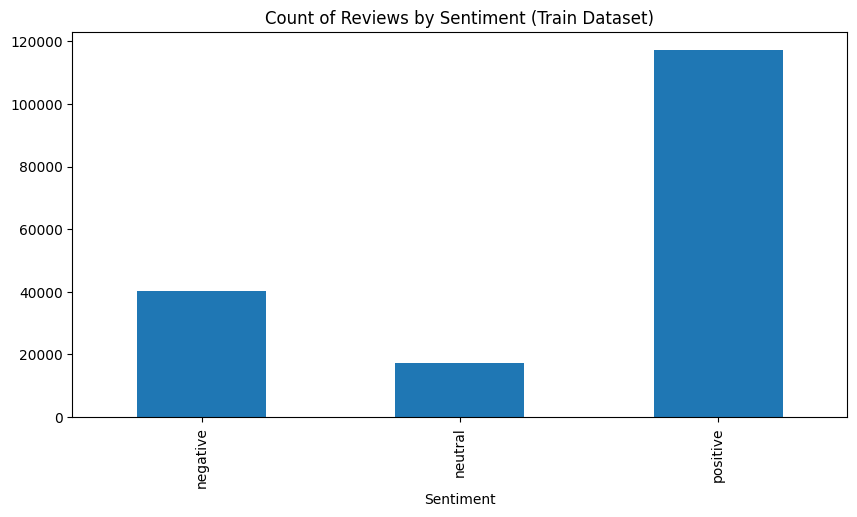

In [3]:
df = pd.read_csv(r"yelp_review_train.csv")
class_name = ['negative','neutral','positive']

# Mapping 1-5 Ratings to Sentiment Class ['Negative','Neutral','Positive']
def get_sentiment(stars):
    if stars<=2:
        return 0 # negative sentiment
    elif stars==3:
        return 1 # neutral sentiment
    else:
        return 2 # positive sentiment

df['stars'] = df.stars.apply(get_sentiment)
df['sentiment_class'] = df['stars'].map({0: 'negative', 1: 'neutral', 2: 'positive'})

# Plot the count of reviews by sentiment class
ax = df['sentiment_class'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Sentiment (Train Dataset)',
          figsize=(10, 5))
ax.set_xlabel('Sentiment')
plt.show()

# Data Pre-processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
# nltk.download('punkt')
# nltk.download('stopwords')

def preprocess_text(text):
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word.isalnum() and word not in stop_words]

    return ' '.join(filtered_words)

In [4]:
# Apply pre-processing to train and test datasets
df['processed_text'] = df['text'].apply(preprocess_text)
df.head()

,text,stars,sentiment_class,processed_text
0,Went for lunch and found that my burger was me...,0,negative,went lunch found burger meh obvious focus burg...
1,I needed a new tires for my wife's car. They h...,2,positive,needed new tires wifes car special order next ...
2,Jim Woltman who works at Goleta Honda is 5 sta...,2,positive,jim woltman works goleta honda 5 stars knowled...
3,Been here a few times to get some shrimp. The...,2,positive,times get shrimp theyve got nice selection dif...
4,This is one fantastic place to eat whether you...,2,positive,one fantastic place eat whether hungry need go...


## Input Data Preparation

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Train-Validation split
df_train, df_val = train_test_split(df, test_size=0.2, random_state=42)
print(df_train.shape, df_val.shape)

(139805, 4) (34952, 4)


100%|████████████████████████████████████████████████████████████████████████| 174757/174757 [02:39<00:00, 1097.13it/s]


% under 128:  89.33433281642509 %


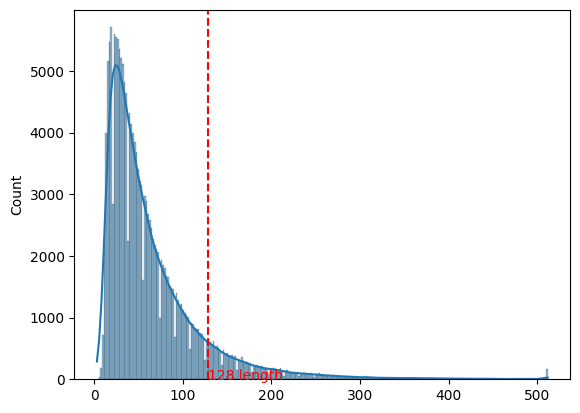

In [6]:
import torch
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

# Loading Pretrained Model
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

# For Choosing Optimal max length after Data Preprocessing
from tqdm import tqdm
token_lens1 = []
for txt in tqdm(df.processed_text):
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens1.append(len(tokens))

MAX_LEN = 128

# Visualizing % of Token below MAX_LEN
ax = sns.histplot(token_lens1,kde=True)
ax.axvline(MAX_LEN, color='red', linestyle = '--')
ax.text(MAX_LEN, 0.0128, '128 length', color = 'red');
sum_under_128 = [1 if elem < MAX_LEN else 0 for elem in token_lens1]
print('% under 128: ', np.sum(sum_under_128) * 100/ len(sum_under_128), '%')
# sns.distplot(token_lens1)
# plt.show()

# Dataset Class
from torch.utils.data import Dataset, DataLoader
class ReviewDataset(Dataset):
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = self.reviews[item]
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            review,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

# DataLoader instances
from mydataset import ReviewDataset
from torch.utils.data import DataLoader

BATCH_SIZE = 32

train_data_loader = ReviewDataset(
    reviews=df_train['processed_text'].values,
    targets=df_train['stars'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

val_data_loader = ReviewDataset(
    reviews=df_val['processed_text'].values,
    targets=df_val['stars'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)

# DataLoader instances
train_data_loader = DataLoader(train_data_loader, batch_size=BATCH_SIZE, num_workers=2)
val_data_loader = DataLoader(val_data_loader, batch_size=BATCH_SIZE, num_workers=2)


## Transformer Implementation

In [7]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)
import torch.nn as nn
from torch.nn import Transformer

from transformers import BertModel, BertConfig, BertTokenizer
class TransformerSentimentClassifier(nn.Module):
    def __init__(self, n_classes, hidden_size=768, num_attention_heads=12, num_layers=12):
        super(TransformerSentimentClassifier, self).__init__()
            
        # BERT backbone
        self.bert_config = BertConfig(
            hidden_size=hidden_size,
            num_attention_heads=num_attention_heads,
            num_hidden_layers=num_layers,
            output_attentions=True 
        )
        
        self.bert = BertModel(config=self.bert_config)

        # Freeze or unfreeze the BERT layers based on the argument
        for param in self.bert.parameters():
            param.requires_grad = True
            
        # Addind Feed Forward Layer for Classification (Prediction head)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128, n_classes)
            # nn.ReLU(),
            # nn.Dropout(p=0.1),
            # nn.Linear(64, n_classes)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs['last_hidden_state'][:, 0, :]  # Taking the [CLS] token for classification purpose
        logits = self.fc(pooled_output)
        return logits

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Customize the transformer architecture by providing the relevant parameters
model = TransformerSentimentClassifier(n_classes=3, hidden_size=512, num_attention_heads=4, num_layers=1)
model = model.to(device)

# Print the model architecture
print(model)

TransformerSentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, elemen

## Model training

In [8]:
EPOCHS = 5

# Set different learning rates for BERT and classifier
optimizer = AdamW([
    {'params': model.bert.parameters(), 'lr': 2e-5},
    {'params': model.fc.parameters(), 'lr': 1e-4},
], correct_bias=False)

# Learning rate scheduler with warm-up
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

# Loss Function
loss_fn = nn.CrossEntropyLoss().to(device)

# Training Setup
def train_epoch(model,data_loader,loss_fn,optimizer,device,scheduler,n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)
        targets = data['targets'].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs,targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        #print(sum(losses)/len(losses))
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)


# Training Loop
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_iterator = tqdm(train_data_loader, desc="Training", leave=False)
    train_acc, train_loss = train_epoch(
        model,
        train_iterator,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )
    print(f'Train loss {train_loss} accuracy {train_acc}')
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )
    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()
    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # Save model at the end of each epoch
    #torch.save(model.state_dict(), f'model_epoch_{epoch + 1}.bin')

    # Save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), f'best_model_final_{val_acc}.bin')
        best_accuracy = val_acc
    print()

# Additional code to print and analyze the training history after all epochs
print("Training History:")
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}: Train Loss {history["train_loss"][epoch]}, Train Acc {history["train_acc"][epoch]}, Val Loss {history["val_loss"][epoch]}, Val Acc {history["val_acc"][epoch]}')


C:\Users\Deepak\anaconda3\envs\pyt\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/5
----------


Train loss 0.46122255481730123 accuracy 0.8309287936769071
Val   loss 0.38222213233297064 accuracy 0.8542858777752346


Epoch 2/5
----------


Train loss 0.3714910831799508 accuracy 0.8593183362540682
Val   loss 0.37187876269453074 accuracy 0.8572613870450904


Epoch 3/5
----------


Train loss 0.3441911967955982 accuracy 0.8688959622331104
Val   loss 0.3671167567951736 accuracy 0.8590924696726939


Epoch 4/5
----------


Train loss 0.32811475398509665 accuracy 0.8749257894925074
Val   loss 0.3641827297273406 accuracy 0.8604657816433967


Epoch 5/5
----------


Train loss 0.31717510523074594 accuracy 0.8782733092521726
Val   loss 0.36215977001788685 accuracy 0.8663023575188831


Training History:
Epoch 1: Train Loss 0.46122255481730123, Train Acc 0.8309287936769071, Val Loss 0.38222213233297064, Val Acc 0.8542858777752346
Epoch 2: Train Loss 0.3714910831799508, Train Acc 0.8593183362540682, Val Loss 0.37187876269453074, Val Acc 0.8572613870450904
Epoch 3: Train Loss 0.3441911967955982, Train Acc 0.8688959622331104, Val Loss 0.3671167567951736, Val Acc 0.8590924696726939
Epoch 4: Train Loss 0.32811475398509665, Train Acc 0.8749257894925074, Val Loss 0.3641827297273406, Val Acc 0.8604657816433967
Epoch 5: Train Loss 0.31717510523074594, Train Acc 0.8782733092521726, Val Loss 0.36215977001788685, Val Acc 0.8663023575188831


## Result analysis

In [9]:
# To Analyze the training history after all epochs
print("Training History:")
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}: Train Loss {history["train_loss"][epoch]}, Train Acc {history["train_acc"][epoch]}, Val Loss {history["val_loss"][epoch]}, Val Acc {history["val_acc"][epoch]}')

# Model Summary
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

# Print the parameters and their values
for name, param in model.named_parameters():
    print(f"Parameter: {name}, Shape: {param.shape}")
    print(param)
    print("=" * 40)

Training History:
Epoch 1: Train Loss 0.46122255481730123, Train Acc 0.8309287936769071, Val Loss 0.38222213233297064, Val Acc 0.8542858777752346
Epoch 2: Train Loss 0.3714910831799508, Train Acc 0.8593183362540682, Val Loss 0.37187876269453074, Val Acc 0.8572613870450904
Epoch 3: Train Loss 0.3441911967955982, Train Acc 0.8688959622331104, Val Loss 0.3671167567951736, Val Acc 0.8590924696726939
Epoch 4: Train Loss 0.32811475398509665, Train Acc 0.8749257894925074, Val Loss 0.3641827297273406, Val Acc 0.8604657816433967
Epoch 5: Train Loss 0.31717510523074594, Train Acc 0.8782733092521726, Val Loss 0.36215977001788685, Val Acc 0.8663023575188831
Total parameters: 20422147
Trainable parameters: 20422147
Parameter: bert.embeddings.word_embeddings.weight, Shape: torch.Size([30522, 512])
Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0287, -0.0005,  0.0015,  ...,  0.0275, -0.0103, -0.0092],
        [-0.0029,  0.0343, -0.0132,  ...,  

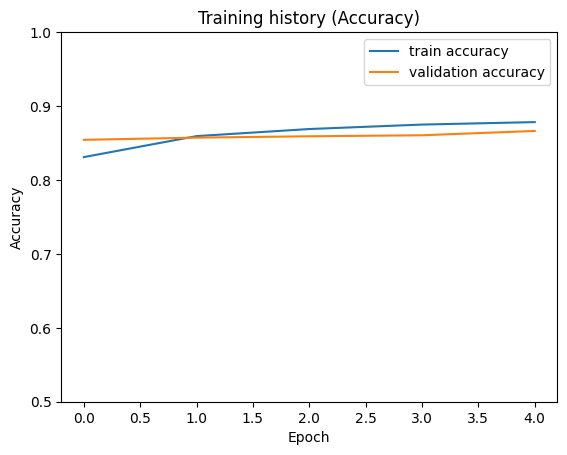

In [10]:
# Accuracy Plot

# Move them to the CPU before plotting
train_acc = [tensor.cpu().numpy() for tensor in history['train_acc']]
val_acc = [tensor.cpu().numpy() for tensor in history['val_acc']]
plt.ylim(0.5, 1)
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history (Accuracy)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

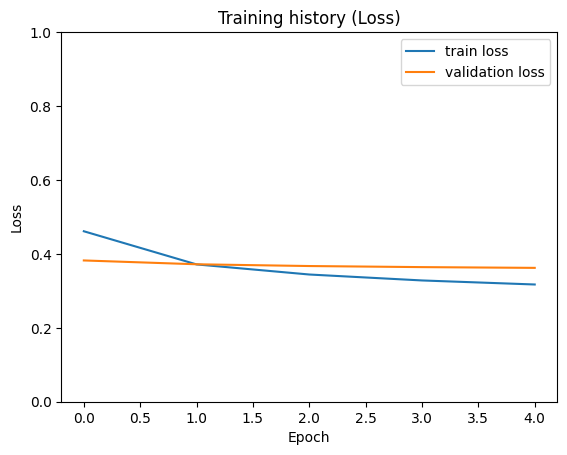

In [11]:
# Loss Plot
train_loss = np.array(history['train_loss'])
val_loss = np.array(history['val_loss'])
plt.ylim(0,1)
plt.plot(train_loss, label='train loss')
plt.plot(val_loss, label='validation loss')
plt.title('Training history (Loss)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [12]:
# Loading the Unseen Yelp Review Test Dataset
df_test = pd.read_csv("yelp_review_test.csv")
df_test['stars'] = df_test.stars.apply(get_sentiment)
df_test.head()

,text,stars
0,"Hidden treasure! Awesome service, delicious fo...",2
1,My family and I have been patients since I wa...,2
2,"I rarely get pedicures, but Blue Nail's practi...",2
3,"We came with a large group, may of the items w...",0
4,The view is great from Morgan's Pier. The bart...,0


In [13]:
# Preprocess Test Dataset
df_test['processed_text'] = df_test['text'].apply(preprocess_text)
df_test.head()

# Loading Test Dataset 
test_data_loader = ReviewDataset(
    reviews=df_test['processed_text'].values,
    targets=df_test['stars'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
)
test_data_loader = DataLoader(test_data_loader, batch_size=BATCH_SIZE, num_workers=2)

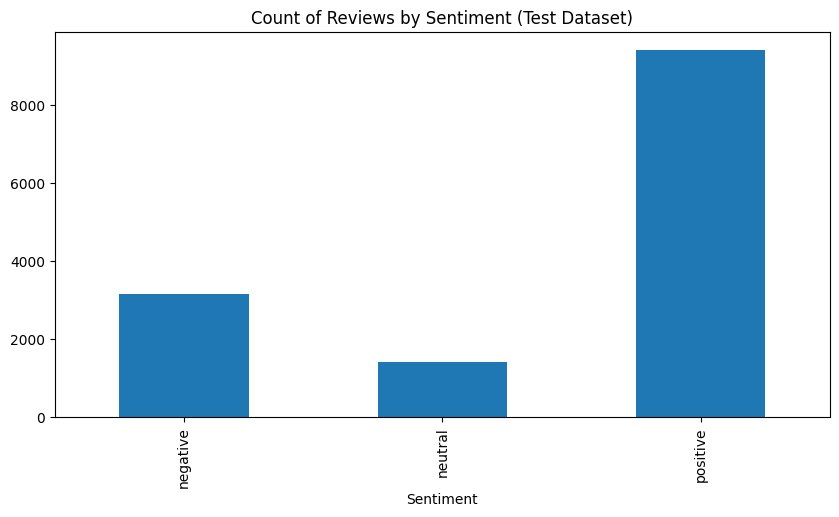

In [14]:
# df_test['stars'] contains sentiment labels (0, 1, 2)
# Map sentiment labels to corresponding classes
df_test['sentiment_class'] = df_test['stars'].map({0: 'negative', 1: 'neutral', 2: 'positive'})
df_test.head()

# Plot the count of reviews by sentiment class
ax = df_test['sentiment_class'].value_counts().sort_index() \
    .plot(kind='bar',
          title='Count of Reviews by Sentiment (Test Dataset)',
          figsize=(10, 5))
ax.set_xlabel('Sentiment')
plt.show()


In [15]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
print("Accuracy on Unseen Test Dataset (yelp_review_test) : ",test_acc.item()*100) 

Accuracy on Unseen Test Dataset (yelp_review_test) :  86.74535050071532


In [16]:
# Get predicted output for all the reviews (Yelp Test Set)
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

              precision    recall  f1-score   support

    negative       0.83      0.86      0.84      3145
     neutral       0.51      0.31      0.38      1416
    positive       0.91      0.95      0.93      9419

    accuracy                           0.87     13980
   macro avg       0.75      0.71      0.72     13980
weighted avg       0.85      0.87      0.86     13980



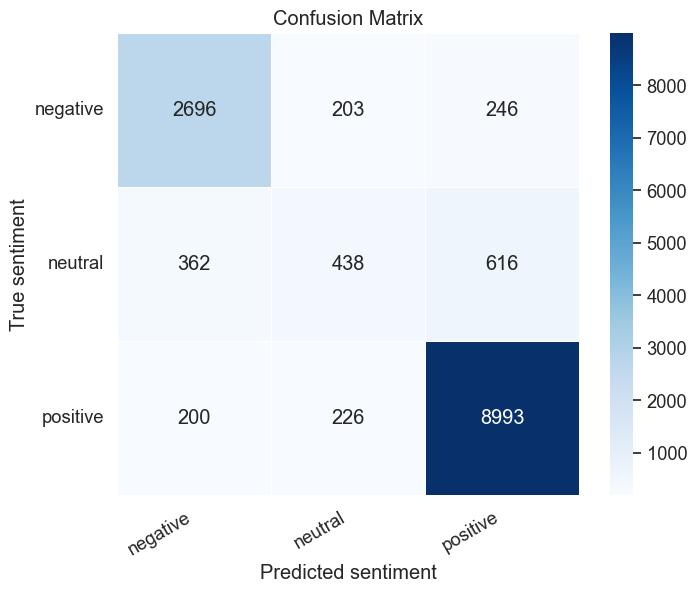

In [17]:
# Printing Evaluation Metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test, y_pred, target_names=class_name))

# Plotting Confusion Matrix
def show_confusion_matrix(confusion_matrix, class_names):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font size
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", linewidths=.5, square=True,
                      xticklabels=class_names, yticklabels=class_names)
    hmap.set_xticklabels(hmap.get_xticklabels(), rotation=30, ha='right')  # Adjust x-axis labels
    hmap.set_yticklabels(hmap.get_yticklabels(), rotation=0, ha='right')  # Adjust y-axis labels
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    plt.title('Confusion Matrix')

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the modified confusion matrix
show_confusion_matrix(cm, class_name)
plt.show()

In [18]:
#Testing Sentiment of New Yelp Reviews
rev1 = "Over priced & our orders have never been good! I know of better places to spend my money"
rev2="They have such a great crew there. Their friendly attitudes and speedy service is comparable to a five star expensive restaurant. They know how to treat customers right. Service like this is rare from one person much less an entire staff. I really like these guys!"
rev=[rev1,rev2]
for review_text in rev:
    encoded_review = tokenizer.encode_plus(
      review_text,
      max_length=MAX_LEN,
      add_special_tokens=True,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)
    output = model(input_ids, attention_mask)
    _, prediction = torch.max(output, dim=1)
    print(f'Review text: {review_text}')
    print(f'Sentiment  : {class_name[prediction]}')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Review text: Over priced & our orders have never been good! I know of better places to spend my money
Sentiment  : negative
Review text: They have such a great crew there. Their friendly attitudes and speedy service is comparable to a five star expensive restaurant. They know how to treat customers right. Service like this is rare from one person much less an entire staff. I really like these guys!
Sentiment  : positive


C:\Users\Deepak\anaconda3\envs\pyt\Lib\site-packages\transformers\tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
